# Notebook Description

This notebook is concerned with the linear regression of the number of days in each of the MJO subphases with the number of raindays each wet season and the total amount of rainfall. This is showing the relatinship between the increasing trend of days in MJO phases 5 and 6 and the increasing rainfal trend in the north west.

**Data**

The data used in this notebook is the AWAP data set and also measurement of the RMM from BOM.

# Packages

In [109]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.array
import cartopy.crs as ccrs
import matplotlib.colors as colors
import datetime as dt
from matplotlib.colors import BoundaryNorm
rb = plt.cm.RdBu
bm = plt.cm.Blues
best_blue = '#9bc2d5'
recherche_red = '#fbc4aa'
wondeful_white = '#f8f8f7'
import glob
import pdb

import warnings
warnings.filterwarnings('ignore')

import matplotlib.gridspec as gridspec

import matplotlib.patches as patch
import matplotlib.colors as mpc
import miscellaneous as misc


import sys
sys.path.append('../functions/')
import trend_functions_2 as tf2

import load_dataset as load
from importlib import reload
import phase_calc_functions as phase_calc

import phase_plot_functions as phase_plot

import subphase_calc_functions as subphase_calc

from miscellaneous import apply_masks

# Data

In [2]:
# Loading awap
awap = load.load_awap()

# Loading RMM
rmm = load.load_rmm()

# Making sure the two are the same length
awap = awap.where(awap.time.isin(rmm.time.values), drop = True)
rmm = rmm.where(rmm.time.isin(awap.time.values), drop = True)
print('AWAP length: {}      RMM length: {} '.format(len(awap.time.values), len(rmm.time.values)))

AWAP length: 7876      RMM length: 7876 


# Wet-Season Calibration

Readjusting the years, so when a resample takes plact, it is just the data for one wet season. If 
this was not done it would be the end half of one wet season and the start of another. This moves that data
from the start of the wet season back or forwards a year (I don't remember), so that they line up

In [3]:
phase_calc = reload(phase_calc)
awap_ws = phase_calc.wet_season_year(awap)

rmm_ws = phase_calc.wet_season_year(rmm)

# Splitting AWAP into the the different phases of the Wheeler and Hendon MJO
awap_split_ws = phase_calc.split_into_1to8(awap_ws, rmm_ws)

In [4]:
awap_sub = subphase_calc.split_into_subphase(awap_ws, rmm)

In [5]:
awap_sub

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, phase: 4, time: 7617)
Coordinates:
  * time     (time) datetime64[ns] 1975-01-01 1975-01-02 ... 2017-12-31
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
Data variables:
    precip   (phase, time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    Information:  Only contains the wet season [10,11,12,1,2,3],rainfall >= 1...

# Rainfall Trends - Count and Sum

<b> Counting the resmaples for awap data </b>

In [6]:
def count_resample(awap_data):
    # countring the rainfall events in each Wheeler and Hendon Phase
    awap_count = awap_data.resample(time = 'y').count(dim = 'time')
    awap_count['time'] = awap_count.time.dt.year
    awap_count = awap_count.rename({'time':'year', 'precip':'number'}) # to match the rmm count
    return awap_count

In [7]:
def sum_resample(awap_data):
    # sumring the rainfall events in each Wheeler and Hendon Phase
    awap_sum = awap_data.resample(time = 'y').sum(dim = 'time')
    awap_sum['time'] = awap_sum.time.dt.year
    awap_sum = awap_sum.rename({'time':'year', 'precip':'number'}) # to match the rmm sum
    return awap_sum

In [8]:
# The number of raindays each wet season.
awap_count = count_resample(awap_ws)

# The total amount of rainfall each wet season.
awap_sum = sum_resample(awap_ws)

In [9]:
awap_count

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, year: 44)
Coordinates:
  * year     (year) int64 1975 1976 1977 1978 1979 ... 2014 2015 2016 2017 2018
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
Data variables:
    number   (year, lat, lon) int64 0 14 16 17 18 16 20 21 ... 0 0 0 0 0 0 0 0

# RMM Subphase Trend

<b> Expanding the dimensions </b> of the RMM count so that there is a value for all lat and 
and lon points. This will make the correlations easier.

In [213]:
# Countring the days in each Wheeler and Hendon Phase
phase_calc = reload(phase_calc)

# The number of days in each MJO phase (1-8) each wet season.
rmm_count = phase_calc.count_in_rmm_phase(rmm_ws)

# The number of days in each MJO subphase each wet season.
rmm_count_sub = phase_calc.resample_phase_to_subphase(rmm_count)

# Selecting just the years that are in the AWAP data set as RMM has a longer recored (till current date always).
rmm_count_sub = rmm_count_sub.isel(year = slice(0,43))

44
---


In [214]:
# As we are only looking at the regression with the enhanced phase, then we can removed all the other phases.
enhanced_phase_year_count = rmm_count_sub.sel(phase = 'enhanced')
enhanced_phase_year_count_expanded = enhanced_phase_year_count.expand_dims({'lat':awap_count.lat.values, 'lon':awap_count.lon.values})
enhanced_phase_year_count_expanded

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, year: 43)
Coordinates:
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * year     (year) int64 1975 1976 1977 1978 1979 ... 2013 2014 2015 2016 2017
    phase    <U8 'enhanced'
Data variables:
    number   (lat, lon, year) float64 44.0 36.0 47.0 26.0 ... 45.0 72.0 35.0

# RMM and AWAP data matching
Making sure there is the same length of data in both data sets.

In [215]:
def match_data(d1, d2):
    d1 = d1.where(d1.year.isin(d2.year.values), drop = True)
    d2 = d2.where(d2.year.isin(d1.year.values), drop = True)
    return d1, d2

In [216]:
awap_sum , enhanced_phase_year_count_expanded= match_data(awap_sum , enhanced_phase_year_count_expanded)

awap_count , enhanced_phase_year_count_expanded = match_data(awap_count , enhanced_phase_year_count_expanded)

# Linear Regression

In [217]:
from scipy.stats import linregress

In [218]:
def helper(x, len_a):
    # split x into 'a' and 'b' parts
    
    xa = x[0:len_a] # awap values (y)
    xb = x[len_a:] # rmm values (x)
    
    grad, inter, r, p, std = linregress(xb,xa)
    
    return grad, p

def linregress_rmm(awap, rmm):
    
    # THis is concating the two different datasets into the one xarry file. They will be split down the middle
    # later on
    len_a = awap.dims['year']
    index_concat = xr.concat([awap,rmm], dim = 'year')

    axis =  index_concat.number.get_axis_num('year')
    arr = index_concat.number
    grad_meta, sig_meta = np.apply_along_axis(helper, arr = arr, 
                                         axis = axis, len_a = len_a)

    grad_vals = xr.Dataset({'precip':(('lat','lon'), grad_meta)},{
        'lat':awap.lat.values,
        'lon':awap.lon.values
    })
    
    
    linregress_sig = xr.Dataset({'precip':(('lat','lon'), sig_meta)},{

        'lat':awap.lat.values,
        'lon':awap.lon.values
    })
    
    # Getting only the significant points
    linregress_sig = linregress_sig.where(linregress_sig.precip < 0.05)
    
    return grad_vals, linregress_sig

The linear regresion between the overall rainfall trend of total rainfall and number of raindays with the amount of days in the enhanced phase.<br>
This returns two data sets. One with the significant points, the other with the regression value.

In [219]:
'''All Rainfall'''
sum_reg, sum_sig = linregress_rmm(awap_sum, enhanced_phase_year_count_expanded)

count_reg, count_sig = linregress_rmm(awap_count, enhanced_phase_year_count_expanded)

In [220]:
sum_reg

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149)
Coordinates:
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
Data variables:
    precip   (lat, lon) float64 0.0 1.696 2.274 2.632 2.848 ... 0.0 0.0 0.0 0.0

In [221]:
# Merging the above datasets into two data sets.
linear_regression = xr.merge([count_reg.rename({'precip':'count'}),
                             sum_reg.rename({'precip':'sum'})])

linear_sig = xr.merge([count_sig.rename({'precip':'count'}),
                             sum_sig.rename({'precip':'sum'})])

In [222]:
linear_regression

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149)
Coordinates:
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
Data variables:
    count    (lat, lon) float64 0.0 0.1792 0.1899 0.1274 ... 0.0 0.0 0.0 0.0
    sum      (lat, lon) float64 0.0 1.696 2.274 2.632 2.848 ... 0.0 0.0 0.0 0.0

# Plotting

This is plotting of the all the linear regression values. The linear regression values between count and sum are quite different and will require different vmax and step size.

**Colour Bar**

In [208]:
# fig  = plt.figure(figsize = (10,10))
# gs = gridspec.GridSpec(2,1, height_ratios = [0.1, 1], hspace = 0.1)
import plotting_functions as pf
pf = reload(pf)

fig, gs = pf.fig_formatter(height_ratios = [0.2,1,0.2,1], num_rows = 4, num_cols = 1, hspace = 0, wspace = 0.2)


vmax = .6
step = .1

cmap, levels = pf.colorbar_creater(vmax, step)

ax = fig.add_subplot(gs[1], projection = ccrs.PlateCarree())
plot = pf.map_plot_with_stippling_and_NWASquare(linear_regression['count'], ax, cmap, levels
                                            , square = 1,
                                             stip_data = linear_sig['count'], sig_alpha = 0.4
                                            )

cax = plt.subplot(gs[0])
pf.create_colorbar(plot, cax, levels,
                   cbar_title =  'Gradient\n(Number of Raindays/Number of Enhanced Phase Days)',
                  cbar_titleSize = 12)


vmax = 12
step = 2

cmap, levels = pf.colorbar_creater(vmax, step)

ax = fig.add_subplot(gs[3], projection = ccrs.PlateCarree())
plot = pf.map_plot_with_stippling_and_NWASquare(linear_regression['sum'], ax, cmap, levels
                                            , square = 1,
                                             stip_data = linear_sig['sum'], sig_alpha = 0.4
                                            )


cax = plt.subplot(gs[2])
pf.create_colorbar(plot, cax, levels, 
                   cbar_title = 'Gradient\n(Rainfall/Number of Enhanced Phase Days)',
                  cbar_titleSize = 12)

TypeError: fig_formatter() got an unexpected keyword argument 'num_rows'

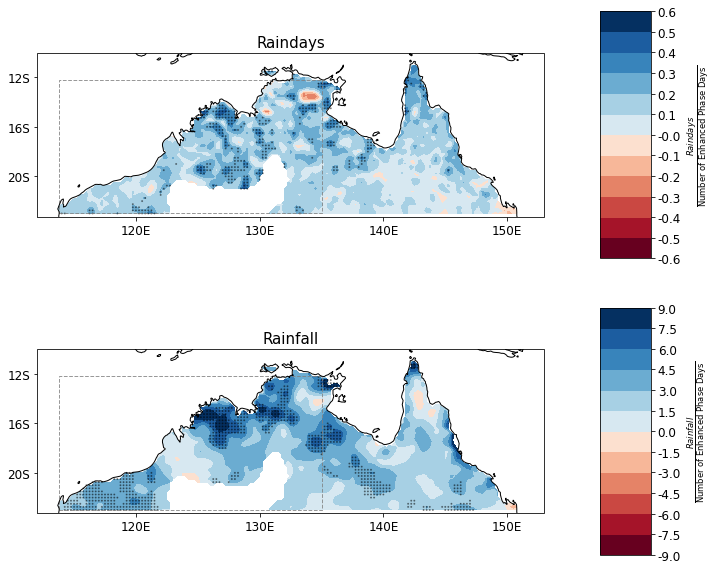

In [229]:
# fig  = plt.figure(figsize = (10,10))
# gs = gridspec.GridSpec(2,1, height_ratios = [0.1, 1], hspace = 0.1)
import plotting_functions as pf
pf = reload(pf)

fig, gs = pf.fig_formatter(height_ratios = [1,1], width_ratios = [1, 0.1], hspace = 0.2, wspace = 0.2)


vmax = .6
step = .1

cmap, levels = pf.colorbar_creater(vmax, step)

ax = fig.add_subplot(gs[0,0], projection = ccrs.PlateCarree())
plot = pf.map_plot_with_stippling_and_NWASquare(linear_regression['count'], ax, cmap, levels
                                            , square = 1,
                                             stip_data = linear_sig['count'], sig_alpha = 0.4
                                            )
ax.set_title('Raindays', size = 15)

cax = plt.subplot(gs[0,1])
pf.create_colorbar(plot, cax, levels,
                   cbar_title =  r"$\frac{Raindays}{\mathrm{Number\ of\ Enhanced\ Phase\ Days}}$",
                  cbar_titleSize = 12, orientation = 'vertical', rotation = 0)


vmax = 9
step = 1.5

cmap, levels = pf.colorbar_creater(vmax, step)

ax = fig.add_subplot(gs[1,0], projection = ccrs.PlateCarree())
plot = pf.map_plot_with_stippling_and_NWASquare(linear_regression['sum'], ax, cmap, levels
                                            , square = 1,
                                             stip_data = linear_sig['sum'], sig_alpha = 0.4
                                            )
ax.set_title('Rainfall', size = 15)

cax = plt.subplot(gs[1,1])
pf.create_colorbar(plot, cax, levels, 
                   cbar_title = r"$\frac{Rainfall}{\mathrm{Number\ of\ Enhanced\ Phase\ Days}}$",
                  cbar_titleSize = 12, orientation = 'vertical', rotation = 0)


# fig.savefig('../images/mjo_and_rainfall_trend_images/linear_regression.png', dpi = 600)